# Predicting patient pay

The goal of this notebook is to predict patient pay for claims data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import numpy as np


from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [2]:
# fetching data
data = pd.read_csv('../pharmacy_tx.csv')

In [3]:
data.rejected.value_counts(normalize=True)

False    0.921866
True     0.078134
Name: rejected, dtype: float64

We throw the claims which are rejected because their patient-pay is always $0$ and that would impact out predictions. They consist around $7.8$ percent of the data.

In [4]:
# we are only taking accepted claims

data = data[data.rejected == False] 

# splitting data into training and test sets

train,test= train_test_split(data,test_size=0.2, shuffle=True, random_state=42)

In [51]:
test.to_csv("test_data.csv")

In [5]:
train_temp=train
test_temp=test

In [47]:
train_temp.groupby(['drug','pharmacy','bin'],as_index=False).patient_pay.mean()

,drug,pharmacy,bin,patient_pay
0,branded antimab,Pharmacy #0,96934,22.342044
1,branded antimab,Pharmacy #0,160389,19.670000
2,branded antimab,Pharmacy #0,322463,11.237691
3,branded antimab,Pharmacy #0,539437,26.368539
4,branded antimab,Pharmacy #0,571569,13.314171
...,...,...,...,...
69905,generic vocopirin,Pharmacy #9,718350,17.580000
69906,generic vocopirin,Pharmacy #9,725700,10.616986
69907,generic vocopirin,Pharmacy #9,756120,13.419474
69908,generic vocopirin,Pharmacy #9,757349,17.786129


We are going to do feature engineering and introduce new features on our training data. Here we introduce 8 features by aggregating over various columns. These features will have two applications : 

1) Help us build a model to predict patient pay.

2) Help us impute claim entries when some of the features like `drug`, `group`, `pcn` or `pharmacy` are missing.

In [6]:
# Feature 1
# grouping by 'drug', 'pharmacy' and 'bin'.
temp = train_temp.groupby(['drug','pharmacy','bin'],as_index=False).patient_pay.mean()
temp['drug_phar_bin'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','bin'], how='left')


# Feature 2
# grouping by 'drug','pharmacy' and 'group'.
temp = train_temp.groupby(['drug','pharmacy','group'],as_index=False).patient_pay.mean()
temp['drug_phar_grp'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','group'], how='left')
# some rows have group missing so we impute those values with 'drug_phar_bin'
train_temp['drug_phar_grp']=train_temp['drug_phar_grp'].fillna(train_temp['drug_phar_bin'])


# Feature 3
# grouping by 'drug','pharmacy' and 'pcn'.
temp = train_temp.groupby(['drug','pharmacy','pcn'],as_index=False).patient_pay.mean()
temp['drug_phar_pcn'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','pcn'], how='left')
# some rows have pcn missing so we impute those values with 'drug_phar_bin'
train_temp['drug_phar_pcn']=train_temp['drug_phar_pcn'].fillna(train_temp['drug_phar_bin'])


# Feature 4
# grouping by 'drug','pharmacy'.
temp = train_temp.groupby(['drug','pharmacy'],as_index=False).patient_pay.mean()
temp['drug_phar'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy'], how='left')


# Feature 5
# grouping by 'drug' and 'diagnosis'.
temp = train_temp.groupby(['drug','diagnosis'],as_index=False).patient_pay.mean()
temp['drug_diag'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug','diagnosis'], how='left')


# Feature 6
# grouping by 'drug' and 'bin'.
temp = train_temp.groupby(['drug','bin'],as_index=False).patient_pay.quantile(0.75)
temp['drug_bin'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug','bin'], how='left')


# Feature 7
# grouping by 'drug' and 'group'.
temp = train_temp.groupby(['drug','group'],as_index=False).patient_pay.quantile(0.75)
temp['drug_grp'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug','group'], how='left')
# some rows have group missing so we impute those values with 'drug_phar_bin'
train_temp['drug_grp']=train_temp['drug_grp'].fillna(train_temp['drug_bin'])


# Feature 8
# grouping by 'drug' and 'pcn'.
temp = train_temp.groupby(['drug','pcn'],as_index=False).patient_pay.quantile(0.75)
temp['drug_pcn'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug','pcn'], how='left')
# some rows have pcn missing so we impute those values with 'drug_phar_bin'
train_temp['drug_pcn']=train_temp['drug_pcn'].fillna(train_temp['drug_bin'])

In [42]:
print(train_temp.shape)
train_temp.head()

(10258707, 17)


,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,drug_phar_bin,drug_phar_grp,drug_phar_pcn,drug_phar,drug_diag,drug_bin,drug_grp,drug_pcn
0,2022-05-26,Pharmacy #28,I68.27,branded prazinib,322463,NaN,HO8HUGL,False,11.09,12.120940,11.090000,12.120940,12.702696,12.829066,12.22,11.09,12.22
1,2022-01-20,Pharmacy #18,G99.93,branded bovirol,664344,NaN,52H8KH0F83K,False,12.46,14.814396,12.460000,14.814396,13.789535,13.282289,17.61,12.46,17.61
2,2022-11-13,Pharmacy #5,I68.27,branded prazinib,664344,TPJD,NaN,False,19.82,13.705529,13.705529,19.820000,12.492624,12.829066,17.11,17.11,19.82
3,2022-03-16,Pharmacy #22,I59.87,generic oxasoted,664344,NaN,STGRDKR1J5RD,False,5.94,8.446412,5.940000,8.446412,8.969989,8.423183,6.56,5.94,6.56
4,2022-12-17,Pharmacy #24,Q72.66,branded ratin,757349,MSCXSG,DGLGRYP,False,23.83,25.756022,26.652835,26.652835,26.192209,25.035298,23.33,23.40,23.40


In [48]:
#train_temp.to_csv("train_temp.csv")

In [8]:
cols=['drug_phar_bin', 'drug_phar_grp','drug_phar_pcn', 
    'drug_phar', 'drug_diag', 'drug_bin', 'drug_grp',
    'drug_pcn']

<AxesSubplot:>

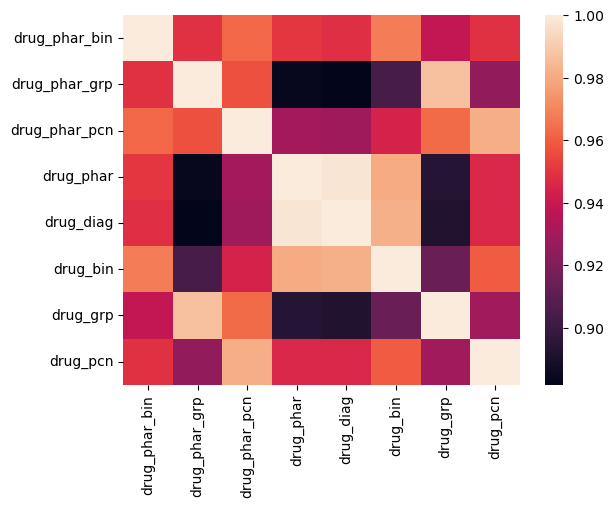

In [9]:
#checking correlation among features

sns.heatmap(train_temp[cols].corr())  

# Models on Patient pay

We are going to experiment with a couple of models using the features defined above and choose the best model after cross-validation. 

### Metrics

Here we choose four metrics to determine which model performs better : 

1) $R^2$ score 

2) Mean absolute error

3) Mean squared error

4) Mean absolute percent error

## Ridge Regression Model

As we observe here the features are very linearly correlated. So we are going to do a `log`-transformation and we will ridge regularisation on the transformed variables to predict patient pay. We also do `KFold` for validation split of our model.

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
scores =[]; i = 1

cols=['drug_phar_bin', 'drug_phar_grp','drug_phar_pcn', 
    'drug_phar', 'drug_diag', 'drug_bin', 'drug_grp',
    'drug_pcn']

for train_index, test_index in kf.split(train_temp):
    train_kf, test_kf = train_temp.iloc[train_index,:], train_temp.iloc[test_index,:]

    lreg = Ridge(alpha=1)

    X = train_kf[cols]
    y = train_kf['patient_pay']

    lreg.fit(np.log(X),np.log(y))

    X_tst = test_kf[cols]
    y_tst = test_kf['patient_pay']

    test_predict = np.exp(lreg.predict(np.log(X_tst)))

    r2 = r2_score(test_predict,y_tst)
    mean_abs = mean_absolute_error(test_predict,y_tst)
    mean_sqr = mean_squared_error(test_predict,y_tst)
    mean_perc = mean_absolute_percentage_error(test_predict,y_tst)

    scores.append(('Ridge_whole',i,r2,mean_abs,mean_sqr,mean_perc*100))
    i+=1

kf_df_whole = pd.DataFrame(scores,columns = ['model','fold_idx', 'r2_score' ,'mean_absolute' ,'mean_sqr' , 'mean_abs_percent'])
kf_df_whole

,model,fold_idx,r2_score,mean_absolute,mean_sqr,mean_abs_percent
0,Ridge_whole,1,0.985742,1.721196,22.640308,6.374461
1,Ridge_whole,2,0.986084,1.714270,22.078494,6.379731
2,Ridge_whole,3,0.985588,1.720664,22.711833,6.385048
3,Ridge_whole,4,0.985673,1.724435,22.932051,6.378900
4,Ridge_whole,5,0.985779,1.721169,22.492189,6.382784


The Ridge model has a mean $r^2$ score of $0.98$ and a mean absolute percent error of $6.37$ percent. Now we are going to use to some tree based models we see if we can get better results.

# Tree Based Models

Here are going to use two tree based models :

1) Random Forests Regressor

2) Gradient Boost Regressor

Since tree based models take longer time to train and we have over $10$ million data, we are going to truncate duplicate variables when training our tree models.

### Random Forests and Ridge regression on the truncated data

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
scores =[]; i = 1

cols=['drug_phar_bin', 'drug_phar_grp','drug_phar_pcn', 
    'drug_phar', 'drug_diag', 'drug_bin', 'drug_grp',
    'drug_pcn', 'patient_pay']

for train_index, test_index in kf.split(train_temp):
    train_kf, test_kf = train_temp.iloc[train_index,:], train_temp.iloc[test_index,:]

    models = [ Ridge(alpha=1),
            RandomForestRegressor(max_depth=10)]

    for j in range(len(models)):

        X_temp = train_kf[cols].drop_duplicates()
        X = X_temp[cols[:-1]]
        y = X_temp['patient_pay']

        X_tst = test_kf[cols[:-1]]
        y_tst = test_kf['patient_pay']

        if j==0 :
            models[j].fit(np.log(X),np.log(y))
            test_predict = np.exp(models[j].predict(np.log(X_tst)))
            
        else :
            models[j].fit(X,y)
            test_predict = models[j].predict(X_tst)

        r2 = r2_score(test_predict,y_tst)
        mean_abs = mean_absolute_error(test_predict,y_tst)
        mean_sqr = mean_squared_error(test_predict,y_tst)
        mean_perc = mean_absolute_percentage_error(test_predict,y_tst)

        scores.append((models[j],i,r2,mean_abs,mean_sqr,mean_perc*100))
    i+=1

kf_df = pd.DataFrame(scores,columns = ['model','fold_idx', 'r2_score' ,'mean_absolute' ,'mean_sqr' , 'mean_abs_percent'])

for i in range(len(kf_df)):
    if i%2 == 0:
        kf_df.iloc[i,0] = 'Ridge_truncated'
    else:
        kf_df.iloc[i,0] = 'Random Forest'
kf_df

,model,fold_idx,r2_score,mean_absolute,mean_sqr,mean_abs_percent
0,Ridge_truncated,1,0.984540,2.128500,27.127335,7.143111
1,Random Forest,1,0.993022,1.399543,11.981088,3.871999
2,Ridge_truncated,2,0.984717,2.127559,26.798328,7.154688
3,Random Forest,2,0.993025,1.391317,11.949570,3.827499
4,Ridge_truncated,3,0.984375,2.131058,27.193699,7.166645
5,Random Forest,3,0.992973,1.402647,11.969364,3.888753
6,Ridge_truncated,4,0.984515,2.130990,27.374120,7.148629
7,Random Forest,4,0.993086,1.402960,11.966631,3.905229
8,Ridge_truncated,5,0.984518,2.130635,27.054930,7.157433
9,Random Forest,5,0.992998,1.407647,11.973048,3.910831


### Gradient boost Regressor model on the truncated data

In [25]:
kf = KFold(n_splits=5, random_state= 10, shuffle=True)
scores =[]; i = 1

cols=['drug_phar_bin', 'drug_phar_grp','drug_phar_pcn', 
    'drug_phar', 'drug_diag', 'drug_bin', 'drug_grp',
    'drug_pcn', 'patient_pay']

for train_index, test_index in kf.split(train_temp):
    train_kf, test_kf = train_temp.iloc[train_index,:], train_temp.iloc[test_index,:]

    model = GradientBoostingRegressor()
    X_temp = train_kf[cols].drop_duplicates()
    X = X_temp[cols[:-1]]
    y = X_temp['patient_pay']

    X_tst = test_kf[cols[:-1]]
    y_tst = test_kf['patient_pay']
    
    model.fit(X,y)
    test_predict = models[j].predict(X_tst)

    r2 = r2_score(test_predict,y_tst)
    mean_abs = mean_absolute_error(test_predict,y_tst)
    mean_sqr = mean_squared_error(test_predict,y_tst)
    mean_perc = mean_absolute_percentage_error(test_predict,y_tst)

    scores.append(('Gradient Boost',i,r2,mean_abs,mean_sqr,mean_perc*100))
    i+=1

kf_df_gradient_boost = pd.DataFrame(scores,columns = ['model','fold_idx', 'r2_score' ,'mean_absolute' ,'mean_sqr' , 'mean_abs_percent'])

kf_df_gradient_boost

,model,fold_idx,r2_score,mean_absolute,mean_sqr,mean_abs_percent
0,Gradient Boost,1,0.993028,1.405866,11.973278,3.902207
1,Gradient Boost,2,0.993061,1.402323,11.888935,3.897153
2,Gradient Boost,3,0.992992,1.405948,11.941333,3.906376
3,Gradient Boost,4,0.993107,1.404715,11.935619,3.897978
4,Gradient Boost,5,0.992998,1.407647,11.973048,3.910831


Overall, tree based models seem to perform better than regression models. We see our $r^2$ score is almost $0.99$ and we have an error of $3.9$ percent.

# Model Comparison

We are going to compare our four models and check how they performed during validation splits.

In [26]:
all_models = pd.concat([kf_df_whole,kf_df,kf_df_gradient_boost], ignore_index=True)
all_models.to_csv('all_models.csv')
del all_models['fold_idx']

all_models.groupby(by='model').mean()

,r2_score,mean_absolute,mean_sqr,mean_abs_percent
model,,,,
Gradient Boost,0.993037,1.405300,11.942443,3.902909
Random Forest,0.993021,1.400823,11.967940,3.880862
Ridge_truncated,0.984533,2.129749,27.109683,7.154101
Ridge_whole,0.985773,1.720347,22.570975,6.380185


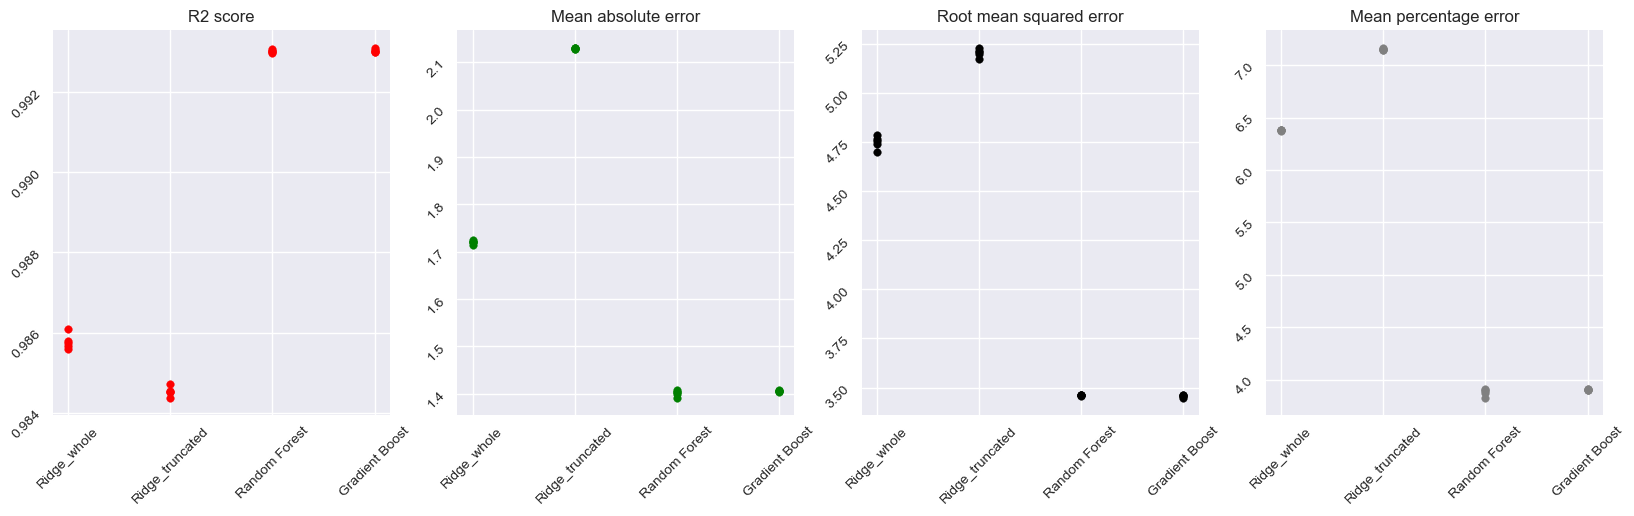

In [27]:
style.use('seaborn')
all_models=pd.read_csv('all_models.csv')
fig, axes = plt.subplots(nrows=1,ncols=4, figsize=(20,5),sharex=True)
axes[0].scatter(all_models['model'],all_models['r2_score'], c ='red',s=30)
axes[0].tick_params(labelrotation=45)
axes[0].set_title('R2 score')

axes[1].scatter(all_models['model'],all_models['mean_absolute'], c = 'green', s=30)
axes[1].tick_params(labelrotation=45)
axes[1].set_title('Mean absolute error')

axes[2].scatter(all_models['model'],np.sqrt(all_models['mean_sqr']), c = 'black', s=30)
axes[2].tick_params(labelrotation=45)
axes[2].set_title('Root mean squared error')

axes[3].scatter(all_models['model'],all_models['mean_abs_percent'], c='grey',s=30)
axes[3].tick_params(labelrotation=45)
axes[3].set_title('Mean percentage error')
plt.show()


We can clearly see Random Forest and Gradient Boost Regressor Models performed better than ridge regression models. We will choose Random Forests as our final model as it took lesser time to train.

# Final Countown - Testing on Unseen data

There are two steps that we have to take to prepare our data for the model:

1) Use the feature engineered variables from the training data and introde these features on the test data.

2) Some of the features would not have been seen during training, so we will carefully fill null entries before testing on the test data.

In [33]:
test_temp = pd.merge(test_temp, train_temp[['drug','pharmacy','bin','drug_phar_bin']].drop_duplicates().dropna(),on=['drug','pharmacy','bin'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','pharmacy','group','drug_phar_grp']].drop_duplicates().dropna(),on=['drug','pharmacy','group'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','pharmacy','pcn','drug_phar_pcn']].drop_duplicates().dropna(),on=['drug','pharmacy','pcn'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','pharmacy','drug_phar']].drop_duplicates().dropna(),on=['drug','pharmacy'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','diagnosis','drug_diag']].drop_duplicates().dropna(),on=['drug','diagnosis'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','bin','drug_bin']].drop_duplicates().dropna(),on=['drug','bin'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','group','drug_grp']].drop_duplicates().dropna(),on=['drug','group'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','pcn','drug_pcn']].drop_duplicates().dropna(),on=['drug','pcn'], how='left')

test_temp.isna().sum() # checking how many entries are null


tx_date                 0
pharmacy                0
diagnosis               0
drug                    0
bin                     0
pcn                663947
group              725529
rejected                0
patient_pay             0
drug_phar_bin_x         0
drug_phar_grp_x         0
drug_phar_pcn_x         0
drug_phar_x             0
drug_diag_x             0
drug_bin_x              0
drug_grp_x              0
drug_pcn_x              0
drug_phar_bin_y        21
drug_phar_grp_y    725774
drug_phar_pcn_y    664191
drug_phar_y             0
drug_diag_y             0
drug_bin_y              0
drug_grp_y         725530
drug_pcn_y         663947
drug_phar_bin          21
drug_phar_grp      725774
drug_phar_pcn      664191
drug_phar               0
drug_diag               0
drug_bin                0
drug_grp           725530
drug_pcn           663947
dtype: int64

In [34]:
# We are filling the null entries with the closest entry that correspnd to it and that is not null.
# While deploying, one might have to define a prefined formula on how to impute these null entries.

test_temp['drug_grp']=test_temp['drug_grp'].fillna(test_temp['drug_bin'])
test_temp['drug_pcn']=test_temp['drug_pcn'].fillna(test_temp['drug_bin'])
test_temp['drug_phar_bin']=test_temp['drug_phar_bin'].fillna(test_temp['drug_bin'])
test_temp['drug_phar_grp']=test_temp['drug_phar_grp'].fillna(test_temp['drug_phar_bin'])
test_temp['drug_phar_pcn']=test_temp['drug_phar_pcn'].fillna(test_temp['drug_phar_bin'])


In [50]:
test_temp.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,drug_phar_bin_x,...,drug_grp_y,drug_pcn_y,drug_phar_bin,drug_phar_grp,drug_phar_pcn,drug_phar,drug_diag,drug_bin,drug_grp,drug_pcn
0,2022-03-16,Pharmacy #22,H60.83,generic colifunene,571569,KB38N,6BYJBW,False,11.43,12.090000,...,11.43,11.43,12.090000,11.43000,11.430000,13.525341,13.559247,11.43,11.43,11.43
1,2022-12-10,Pharmacy #29,I68.27,branded prazinib,571569,KB38N,6BYJBW,False,5.79,5.931600,...,5.79,5.79,5.931600,5.79000,5.790000,12.766380,12.829066,5.79,5.79,5.79
2,2022-09-25,Pharmacy #27,G51.87,generic prazinib,664344,NaN,TFZOR5R49,False,10.72,10.592317,...,10.72,NaN,10.592317,10.72000,10.592317,10.658195,10.674657,10.72,10.72,10.72
3,2022-09-20,Pharmacy #40,U61.13,branded momudobatin,96934,S76J7V6,NaN,False,62.35,58.997260,...,NaN,63.18,58.997260,58.99726,62.512836,57.857892,53.704793,62.98,62.98,63.18
4,2022-01-19,Pharmacy #14,Z98.86,generic keglusited,691847,XH4T3,GOM8K0,False,15.55,15.682487,...,15.55,15.55,15.682487,15.55000,15.550000,13.673011,13.503777,17.91,15.55,15.55


In [49]:
test_temp.to_csv("test_temp.csv")

In [31]:
cols = ['drug_phar_bin','drug_phar_grp','drug_phar_pcn','drug_diag','drug_bin',
 'drug_grp','drug_pcn','patient_pay']

train_temp2=train_temp[cols].drop_duplicates()

rf = RandomForestRegressor(max_depth=10)

rf.fit(train_temp2[cols[:-1]], train_temp2['patient_pay'])


RandomForestRegressor(max_depth=10)

In [35]:
pred = rf.predict(test_temp[cols[:-1]])
y_test = test_temp['patient_pay']

print('Test Predictions :')

print('R2 score : ' , r2_score(pred,y_test))
print('MAE : ' ,mean_absolute_error(pred,y_test))
print('RMSE : ' ,np.sqrt(mean_squared_error(pred,y_test)))
print('MAPE : ',mean_absolute_percentage_error(pred,y_test)*100)

Test Predictions :
R2 score :  0.9920472010780876
MAE :  1.5422491594539391
RMSE :  3.706737104795684
MAPE :  4.315484390565158


In [36]:
rf.feature_importances_

array([1.44391142e-04, 1.53923819e-02, 8.88662013e-03, 3.19983613e-04,
       4.44365938e-04, 7.57576146e-01, 2.17236111e-01])

In [37]:
test['predictions'] = pred

In [38]:
test[ abs(test.predictions - test.patient_pay) > 50]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,predictions
764652,2022-01-23,Pharmacy #46,D13.25,branded plazamiglutic,725700,BZ22Z2,ZOYKF0N5NEO,False,120.17,64.891125
70216,2022-01-05,Pharmacy #0,Z66.42,branded diadaric,664344,NaN,RGVK1,False,117.03,66.341283
8531373,2022-08-20,Pharmacy #30,Q72.66,branded tugesutin,725700,BZ22Z2,ZOYKF0N5NEO,False,261.19,210.788594
11845096,2022-11-09,Pharmacy #25,B45.03,branded monemodiase,322463,NaN,0TZ9XYJZJH,False,476.45,325.294444
3039484,2022-03-28,Pharmacy #29,U06.52,branded tugesutin,664344,CS8580,NaN,False,243.77,184.493563
...,...,...,...,...,...,...,...,...,...,...
163207,2022-01-08,Pharmacy #7,Q72.66,branded tugesutin,322463,NaN,0TZ9XYJZJH,False,261.19,203.675799
3647577,2022-04-16,Pharmacy #53,Q72.66,branded tugesutin,664344,KBOSN,NaN,False,250.95,186.671632
37035,2022-01-04,Pharmacy #53,U06.52,branded tugesutin,725700,NaN,DYGBI610ZY,False,254.20,194.999534
114613,2022-01-06,Pharmacy #16,Q72.66,branded tugesutin,664344,BIZF,QK6BI1N61,False,261.19,210.768559


In [39]:
test[(test.drug=='branded tugesutin') &(test.pcn=='CS8580') &(test.pharmacy=='Pharmacy #29')]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,predictions
3039484,2022-03-28,Pharmacy #29,U06.52,branded tugesutin,664344,CS8580,NaN,False,243.77,184.493563
5277794,2022-05-28,Pharmacy #29,U61.13,branded tugesutin,664344,CS8580,NaN,False,185.10,184.493563
8700546,2022-08-24,Pharmacy #29,U06.52,branded tugesutin,664344,CS8580,NaN,False,185.10,184.493563
7376180,2022-07-22,Pharmacy #29,Q72.66,branded tugesutin,664344,CS8580,NaN,False,185.10,184.493563
11132998,2022-10-22,Pharmacy #29,U61.13,branded tugesutin,664344,CS8580,NaN,False,185.10,184.493563
1925762,2022-02-25,Pharmacy #29,Q72.66,branded tugesutin,664344,CS8580,NaN,False,185.10,184.493563
5941564,2022-06-16,Pharmacy #29,Q72.66,branded tugesutin,664344,CS8580,NaN,False,185.10,184.493563


In [40]:
test[(test.drug=='branded prefluflomycin') &(test.pcn=='MSCXSG') &(test.pharmacy=='Pharmacy #37')]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,predictions
4537468,2022-05-10,Pharmacy #37,C14.36,branded prefluflomycin,757349,MSCXSG,DGLGRYP,False,268.93,269.3285
12811200,2022-12-03,Pharmacy #37,C14.36,branded prefluflomycin,757349,MSCXSG,DGLGRYP,False,268.93,269.3285
7337982,2022-07-21,Pharmacy #37,I91.91,branded prefluflomycin,757349,MSCXSG,DGLGRYP,False,268.93,269.3285
8551379,2022-08-21,Pharmacy #37,I91.91,branded prefluflomycin,757349,MSCXSG,DGLGRYP,False,268.93,269.3285
166551,2022-01-08,Pharmacy #37,I91.91,branded prefluflomycin,757349,MSCXSG,DGLGRYP,False,356.16,269.3285


Conclusions :  After doing some error analysis we found that our prediction differs more from actual patient pay for entries where the deductible of the patient pay hasn't been fulfilled yet. 

Recommendations :  One might train two models with two amounts predicting `copay_with_deductible` and `copay_without_deductible`; so that doctors might ask the patient whether they have met the deductible or not and prescribe the drug accordingly.